In [961]:
import math
import inspect
import simpy
# import scipy.stats as scs
from numpy import random
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var][0]

Задачу, представленную ниже, необходимо
- решить аналитически (выслать точное решение, оформленное в Word'е, LaTeX'е, Jupyter'е, или скан с разборчивым почерком

- написать и выслать имитационную модель в Python

- ввести и обосновать метрику совпадения экспериментального решения с теоретическим (творческая компонента).

-   Оцените скорость сходимости решения по введенной метрике (ошибка как функция номера итерации) или разъясните причины отсутствия сходимости

$V = 20 \% 4 + 1 = 1$

Задача 1

В парикмахерской работают **3 мастера**, а в зале ожидания расположены **3 стула**. Поток клиентов имеет интенсивность **12 клиентов в час**. Среднее **время обслуживания составляет 20 мин**. Определить показатели работы СМО.

MMcK Queue - Multiserver, Finite-Capacity System

$\lambda = 12$ - интенсивность потока клиентов

$\mu = 3$ - интенсивность обслуживания

$\rho = \dfrac{\lambda}{\mu} = \dfrac{12}{3} = 4$ -  интенсивность траффика

$ K = 6$ - максимальное кол-во клиентов

$ c = 3$ - кол-во "серверов"

In [246]:
lam = 12
mu = 3
rho = lam / mu

Вероятность попадания в каждое из возможных состояний: 


$$p_0 = \left[ \sum^c_{n=0} \frac{\rho^n}{n!} + \frac{\rho^c}{c!} \sum^{k-c}_{n=1} \left(\frac{\rho}{c}\right)^n  \right]^{-1}$$

<!-- $$p_0 = \left[ \frac{3^0}{0!} + \frac{3^1}{1!} + \frac{3^2}{2!} + \frac{3^2}{2!} \left(\frac{3^1}{2^1}+ \frac{3^2}{2^2}+ \frac{3^3}{2^3}+ \frac{3^4}{2^4} \right) \right]^{-1} = 0,0158 = 0,016$$ -->

$$\begin{equation*}
P_n = 
 \begin{cases}
   \dfrac{\rho^n}{n!}p_0 &\text{,if $n = 1,2,... , c$}\\
   \dfrac{\rho^c}{c!}\left(\dfrac{\rho}{c}\right)^{n-c}p_0 &\text{,if $n = c+1, ..., K$}
 \end{cases}
\end{equation*}$$

In [4]:
def calculate_p0(c, K, rho):
    first_sum = sum([rho**n / math.factorial(n) for n in range(c + 1)])
    second_sum = sum([(rho/c)**n for n in range(1, K - c + 1)])
    return (first_sum + (rho**c / math.factorial(c)) * second_sum)**(-1)

def calculate_Pn(n, rho, c, K, p_0):
    if 1 <= n <= c:
        return (rho**n / math.factorial(n)) * p_0
    elif c + 1 <= n <= K:
        return (rho**c / math.factorial(c)) * (rho/c)**(n - c) * p_0
    else:
        raise ValueError('n has to be an int number from from 1 to K')

In [247]:
c = 3
K = 6
rho = 4
p_0 = calculate_p0(c, K, rho)

# for i in range(1, 7):
#     print(f"p_{i} = calculate_Pn({i}, rho, c, K, p_0)")

p_1 = calculate_Pn(1, rho, c, K, p_0)
p_2 = calculate_Pn(2, rho, c, K, p_0)
p_3 = calculate_Pn(3, rho, c, K, p_0)
p_4 = calculate_Pn(4, rho, c, K, p_0)
p_5 = calculate_Pn(5, rho, c, K, p_0)
p_6 = calculate_Pn(6, rho, c, K, p_0)

prob_list = [p_0, p_1, p_2, p_3, p_4, p_5, p_6]

assert abs(sum(prob_list) - 1) < 10**(-3)

for i, j in enumerate(prob_list):
    print(f"p_{i} = %.4f" % j)

p_0 = 0.0122
p_1 = 0.0487
p_2 = 0.0974
p_3 = 0.1299
p_4 = 0.1732
p_5 = 0.2309
p_6 = 0.3078


# Теор показатели

In [331]:
Notation = {
    "Abs_capacity": {"name": "Абсолютная пропускная способность СМО"},
    "Rel_capacity": {"name": "Относительная пропускная способность СМО"},
    "Mean_busy_cycle": {"name": 'Средняя продолжительность периода занятости СМО'},
    "System_utilization": {"name": "Коэффициент использования СМО"},
    "Q_time_avg": {"name": "Среднее время ожидания заявки в очереди"},
    "Mean_response_time": {"name": "Среднее время пребывания заявки в СМО"},
    "P_reject": {"name": "Вероятность отказа заявке в обслуживании без ожидания"},
    "Q_time_DF": {"name": "Закон распределения времени ожидания заявки в очереди"},
    "P_immediate": {"name": "Вероятность того, что вновь поступившая заявка немедленно будет принята к обcлуживанию"},
    # "": {"name": "Закон распределения времени пребывания заявки в СМО"},
    "Q_num_avg": {'name': 'Среднее число заявок, находящихся в очереди'},
    'N_cust_avg': {'name': 'Среднее число заявок, находящихся в СМО'}
}


1.1. Абсолютная пропускная способность СМО – среднее число заявок

1.2. Относительная пропускная способность СМО 

1.3. Средняя продолжительность периода занятости СМО

1.4. Коэффициент использования СМО – средняя доля времени, в течение которого СМО занята обслуживанием заявок

2.1. Среднее время ожидания заявки в очереди

2.2. Среднее время пребывания заявки в СМО

2.3. Вероятность отказа заявке в обслуживании без ожидания

2.4. Вероятность того, что вновь поступившая заявка немедленно будет принята к обcслуживанию

2.5. Закон распределения времени ожидания заявки в очереди

2.7. Среднее число заявок, находящихся в очереди

$r = \dfrac{\rho}{c}$

Q_num_avg = $\bar Q = \dfrac{\rho^c r p_0}{c!(1-r)^2} \left( 1+(K-c)r^{K-c+1}- (K-c+1)r^{K-c} \right)$

2.8. Среднее число заявок, находящихся в СМО

N_cust_avg = $\bar N = \bar Q + \rho(1 - p_k)$

In [8]:
def calculate_Q_num_avg(rho, c, K, r, p_0):
    Q_num_avg = (
        (rho**c * r * p_0) / (math.factorial(c) * (1 - r)**2)
        * (1 + (K - c)*r**(K - c + 1) - (K - c + 1) * r**(K - c))
    )
    return Q_num_avg

In [844]:
P_reject = p_6

Abs_capacity = lam * (1 - P_reject)

Rel_capacity = (1 - P_reject)

Mean_busy_cycle = (1 - p_0) / (lam * p_0)

System_utilization = 1 - p_0

r = rho / c

Q_num_avg = calculate_Q_num_avg(rho, c, K, r, p_0)

bar_lambda = lam * (1 - P_reject)

Q_time_avg = Q_num_avg / bar_lambda

N_cust_avg = Q_num_avg + rho * (1 - p_6)

Mean_response_time = N_cust_avg / lam

P_immediate = p_0 + p_1 + p_2

In [845]:
for key in Notation.keys():
    if key not in ('Q_time_DF', ):
        try:
            Notation[key]['value'] = globals()[key]
        except KeyError:
            print(key, 'not calculated')

In [846]:
for i, j in Notation.items():
    if j.get('value'):
        print(j['name'], ': ', '%.3f'%j['value'], sep='')

Абсолютная пропускная способность СМО: 8.306
Относительная пропускная способность СМО: 0.692
Средняя продолжительность периода занятости СМО: 6.761
Коэффициент использования СМО: 0.988
Среднее время ожидания заявки в очереди: 0.188
Среднее время пребывания заявки в СМО: 0.361
Вероятность отказа заявке в обслуживании без ожидания: 0.308
Вероятность того, что вновь поступившая заявка немедленно будет принята к обcлуживанию: 0.158
Среднее число заявок, находящихся в очереди: 1.558
Среднее число заявок, находящихся в СМО: 4.327
Вероятность пустования системы: 0.012


2.5. Закон распределения времени ожидания заявки в очереди

2.6. Закон распределения времени пребывания в очереди

$F_W(t)=1-\sum\limits_{n=c}^{K-1}\pi_n \sum\limits_{i=0}^{n-c}\dfrac{(c\mu t)^i e^{-c\mu t}}{i!}$

$F_W(0)=p_0+p_1+p_2$

In [657]:
# tbd 

# Simulation

In [413]:
# for i, j in d.items():
#     index = 

In [696]:
class MMcK_Queue:
    def __init__(self, env, lambda_, mu, c, K, seed=None, print_logs=False):
        self.env = env
        self.lambda_ = lambda_
        self.mu = mu
        # self.K = K 
        self.queue = simpy.Store(env, capacity=K - c)
        self.server = simpy.Resource(self.env, capacity=c)
        self.customer_visits_data = {}
        self.print_logs = print_logs
        # self.metrics = {}

    
    def run_until_time(self, runtime=float('inf'), max_iter=None):

        assert runtime != float('inf') or max_iter, 'Either runtime or max_iter has to be set' 

        try:
            self.env.process(self.generate_arrivals(max_iter))
            self.env.run(until=runtime)
        except simpy.Interrupt:
            return self.customer_visits_data
            
        return self.customer_visits_data
    
    
    def generate_arrivals(self, max_iter=None):
        self.current_customer = id_num = 0
        while True:
            # wait for the next customer
            yield self.env.timeout(random.exponential(1/self.lambda_))  # wait a random entry time
            arrival_time = self.env.now

            if self.print_logs:
                print(f"Customer {id_num} arrived at {arrival_time:.2f}")
                
            system_empty = len(self.queue.items) + len(self.server.users) == 0
            
            self.customer_visits_data[id_num] = {'arrival_time': arrival_time,
                                                 'system_empty': system_empty}

            # a customer arrives
            # simpy.Store automatically drops items when out of capacity
            # but in order to save data let's check it
            is_free_queue_space = (len(self.queue.items) < self.queue.capacity)
            if is_free_queue_space:
                # admit to queue and enter process for them
                self.customer_visits_data[id_num]['rejected'] = False
                self.queue.put(id_num) # got into the queue 
                self.env.process(self.process_customer(id_num, max_iter))
                
            else:
                # record their attempted entry but do not enter the queue
                self.customer_visits_data[id_num]['rejected'] = True
                
                if self.print_logs:
                    print(f"Customer {id_num} was rejected at {self.env.now:.2f}")

                if max_iter and id_num >= max_iter:
                    raise simpy.Interrupt('Max iteration achieved') 
                
            id_num += 1

    
    def process_customer(self, id_num, max_iter):
        # serve a customer at the front of the queue
        with self.server.request() as request:
            yield request # Вроде здесь как раз и ждем своей очереди на ресурс
            
            assert self.queue.items[0] == id_num, 'Wrong Customer ID got to the server'
            
            self.queue.get()
    
            self.customer_visits_data[id_num]['waiting'] = \
            self.env.now - self.customer_visits_data[id_num]['arrival_time']
            self.customer_visits_data[id_num]['service_start_time'] = self.env.now

            if self.print_logs:
                print(f"Customer {id_num} went to barber at {self.env.now:.2f}")

            # непосредственно сама стрижка
            service_time = random.exponential(1/self.mu)
            yield self.env.timeout(service_time)

            if self.print_logs:
                print(f"Customer {id_num} got service and left at {self.env.now:.2f}")
            
            self.customer_visits_data[id_num]['service'] = service_time
            self.customer_visits_data[id_num]['leaving_time'] = self.env.now

            if max_iter and id_num >= max_iter:
                    raise simpy.Interrupt('Max iteration achieved')
            


Проверим как оно работает: 


In [660]:
env = simpy.Environment()
simulation = MMcK_Queue(env, lambda_=lam, c=c,K=K, mu=mu, print_logs=1)
res = pd.DataFrame(simulation.run_until_time(max_iter=10).values())

Customer 0 arrived at 0.02
Customer 0 went to barber at 0.02
Customer 1 arrived at 0.02
Customer 1 went to barber at 0.02
Customer 1 got service and left at 0.02
Customer 2 arrived at 0.05
Customer 2 went to barber at 0.05
Customer 3 arrived at 0.13
Customer 3 went to barber at 0.13
Customer 4 arrived at 0.15
Customer 5 arrived at 0.19
Customer 3 got service and left at 0.30
Customer 4 went to barber at 0.30
Customer 0 got service and left at 0.51
Customer 5 went to barber at 0.51
Customer 5 got service and left at 0.56
Customer 2 got service and left at 0.58
Customer 4 got service and left at 0.77
Customer 6 arrived at 0.84
Customer 6 went to barber at 0.84
Customer 7 arrived at 0.92
Customer 7 went to barber at 0.92
Customer 7 got service and left at 0.94
Customer 6 got service and left at 1.02
Customer 8 arrived at 1.14
Customer 8 went to barber at 1.14
Customer 9 arrived at 1.22
Customer 9 went to barber at 1.22
Customer 10 arrived at 1.25
Customer 10 went to barber at 1.25
Custome

# Оценка (8.5 :D)

Посчитаем показатели (какие-то). 

Вроде бы, если знать вероятность отказа (P_reject), среднее время пребывания в очереди (Q_time_avg) и вероятности p_0 (что система ~~прогнила~~ пустует), то все остальные должны сходиться

Как буду их проверять?

Так, у нас есть значения теоретических показателей в пределе.

Если брать просто средние, то как будто неправильно, тк зацепим начало, где еще не вышли на асимптоту

**Решение:** (уровня класса коррекции, естественно)

Определим на глазок, начиная с какой итерации I примерно показатели выходят на +/- константный уровень

Возьмем средние значения показателей симуляций по [:I, MAX_ITER] за EXPERIMENT_NUM кол-во экспериментов

По идее, при "большом" кол-ве можем делать z-test, тк среднее по независимым экспериментам из одного распределения с матожиданием равным теор. показателю 

In [946]:
MAX_ITER = 10000
EXPERIMENT_NUM = 200

In [947]:
# для сходимостей
P_reject_list = [] 
Q_time_avg_list = []
p_0_list = []

# сами значения
P_reject_values_of_exp = []
Q_time_avg_values_of_exp = []
p_0_values_of_exp = []

for ex in tqdm(range(EXPERIMENT_NUM)):
    env = simpy.Environment()
    simulation = MMcK_Queue(env, lambda_=lam, c=c,K=K, mu=mu)
    
    # save "complete" iterations
    sim_res = pd.DataFrame(simulation.run_until_time(max_iter=MAX_ITER).values()).iloc[:MAX_ITER, :]

    P_reject_values_of_exp.append(sim_res.rejected)
    Q_time_avg_values_of_exp.append(sim_res.waiting)
    p_0_values_of_exp.append(sim_res.system_empty)
    
    # сохраняем результаты 
    P_reject_list.append(sim_res.rejected.expanding(1).mean())
    Q_time_avg_list.append(sim_res.waiting.expanding(1).mean())
    p_0_list.append(sim_res.system_empty.expanding(1).mean())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:23<00:00,  8.69it/s]


In [948]:
def plot_expirements(experiment_results, var_name):
    
    x_values = list(range(len(experiment_results[0])))

    for result in experiment_results:
        plt.plot(x_values, result)

    plt.xlabel('Num of iteration')
    plt.ylabel(var_name)
    plt.title(f'Sim. {Notation[var_name]["name"]}')

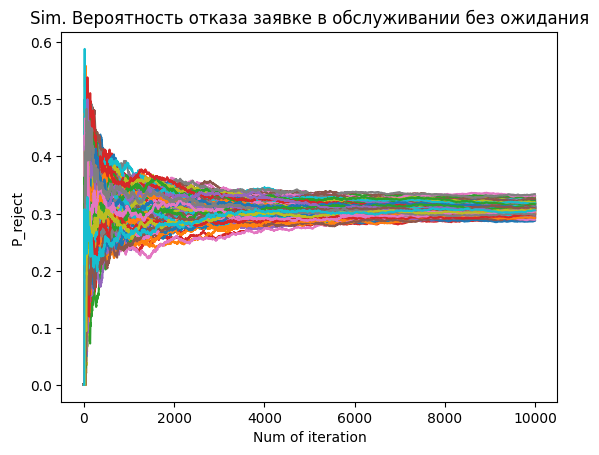

In [949]:
plot_expirements(P_reject_list, 'P_reject')

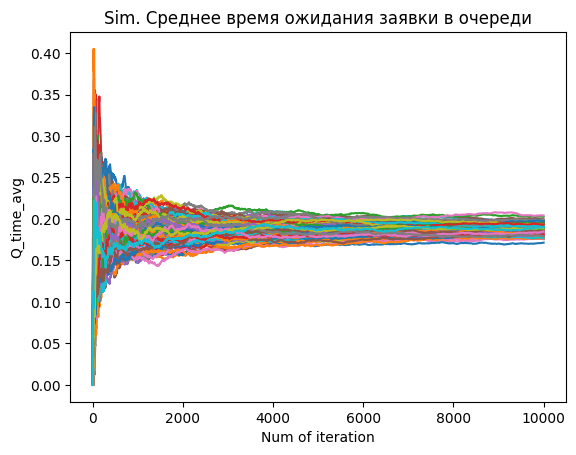

In [950]:
plot_expirements(Q_time_avg_list, 'Q_time_avg')

In [951]:
Notation['p_0'] = {'name': 'Вероятность пустования системы', 'value': p_0}

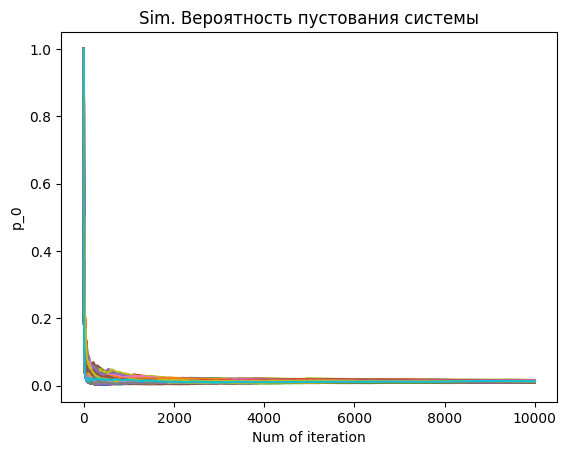

In [952]:
plot_expirements(p_0_list, 'p_0')

Ну грубо говоря, после 3000 итераций выходим на +/- устойчивые значения

In [953]:
START_ASYMP = 6000

Как считать? 

- Можем сделать для p_0 и вероятности отказа тест по всем (MAX_ITER - START_ASYMP) * EXPERIMENT_NUM, тогда будем проверять, что у нас каждое наблюдение X_ij (i итерация, j эксперимент) имеет матожидание == теор. значению

  (это относительно более жесткое требование, но как будто тогда совсем хорошо)

- Можем считать по средним наблюдений (которые уже типа вышли некоторый константный тренд) по каждому эксперименту. Будем проверять, получается, что после какого-то момента у нас в среднем близки к теоретическим


In [954]:
from scipy import stats

def z_test(data: np.array, alpha, mu):
    z_statistic = (data.mean() - mu) / (data.std(ddof=1) / (len(data)**0.5))
    p_value = 2 * (1 - stats.norm.cdf(abs(z_statistic)))
    print('p-value', round(p_value, 3), ';', '')
    if p_value < alpha:
        return "Reject null hypothesis"
    else:
        return "Fail to reject null hypothesis"

In [955]:
# ALL Values 

# p_0

z_test(
    np.array(list(itertools.chain(*[i[START_ASYMP:] for i in p_0_values_of_exp]))), 
    alpha=0.05,
    mu=p_0
)

p-value 0.871 ; 


'Fail to reject null hypothesis'

In [956]:
# ALL Values 

# P_reject_list
z_test(
    np.array(list(itertools.chain(*[i[START_ASYMP:] for i in P_reject_values_of_exp]))), 
    alpha=0.05,
    mu=P_reject
)

p-value 0.077 ; 


'Fail to reject null hypothesis'

Теперь про тест уже на средние по эксперименту 

In [957]:
# Avg Values 

# P_reject_list
z_test(
    np.array(P_reject_list)[:, START_ASYMP:].mean(axis=1), 
    alpha=0.05,
    mu=P_reject
)

p-value 0.316 ; 


'Fail to reject null hypothesis'

In [958]:
# Avg Values 

# p_0
z_test(
    np.array(p_0_list)[:, START_ASYMP:].mean(axis=1), 
    alpha=0.05,
    mu=p_0
)

p-value 0.149 ; 


'Fail to reject null hypothesis'

In [959]:
print('разница между теор и эмп p_0: ', round(np.array(p_0_list)[:, START_ASYMP:].mean(axis=1).mean() - p_0, 5))

разница между теор и эмп p_0:  0.00019


In [960]:
# ALL Values 

# Q_time_avg

z_test(
    np.array(Q_time_avg_list)[:, START_ASYMP:].mean(axis=1), 
    alpha=0.05,
    mu=Q_time_avg
)

p-value 0.587 ; 


'Fail to reject null hypothesis'

Формально выбранным способом не обнаружили стат значимых расхождений между "вышедшими на асимптотические значения" средними по эмпирике

## Сходимость

In [974]:
def plot_avg(experiment_results, var_name, theor_value):
    
    x_values = list(range(len(experiment_results)))

    plt.plot(x_values, experiment_results)

    plt.axhline(y=theor_value, color='r', linestyle='--')

    plt.xlabel('Num of iteration')
    plt.ylabel(var_name)
    plt.title(f'Sim. Avg in k-iter {Notation[var_name]["name"]}')

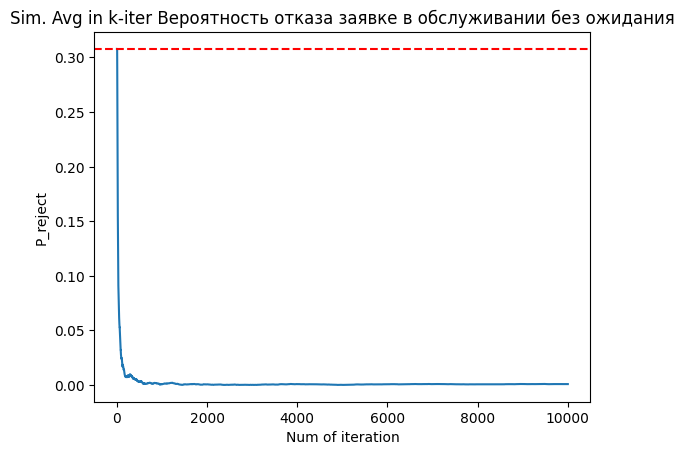

In [988]:
plot_avg(abs(np.array(P_reject_list).mean(axis=0) - P_reject), 'P_reject', P_reject)

In [1040]:
# convergence_estimation писал ChatGPT, каюсь

def convergence_estimation(Array, theoretical_number, var_name):
    
    # Define the function for convergence
    def convergence_function(N, A):
        return A / N  # You can choose a different function depending on the expected behavior
    
    # Fitting the regression model
    n = np.arange(len(Array))  # Index of the Array
    popt, pcov = curve_fit(convergence_function, n, abs(Array - theoretical_number))
    
    # Estimated parameters
    A_est = popt

    # Plot the convergence function
    plt.plot(n, abs(Array - theoretical_number), label='Abs. diff')
    plt.plot(n, convergence_function(n, A_est), 'r-', label='Convergence Function')
    plt.xlabel('Index of the Array')
    plt.ylabel('Difference from Theoretical Number')
    plt.title(f'{var_name} convergence')
    plt.xlim(0, 200) 
    plt.legend()
    plt.show()
    
    print(f'The estimated convergence speed function is f(N) = {A_est}  /  N)')

    # return A_est

# np.array(P_reject_list).mean(axis=0)

In [1008]:
# np.array(P_reject_list).mean(axis=0) - P_reject

/var/folders/yh/4jky_nln065c8nrzc6phgjjdt0k6bs/T/ipykernel_43257/909441150.py:7: RuntimeWarning: divide by zero encountered in divide
  return A / N  # You can choose a different function depending on the expected behavior


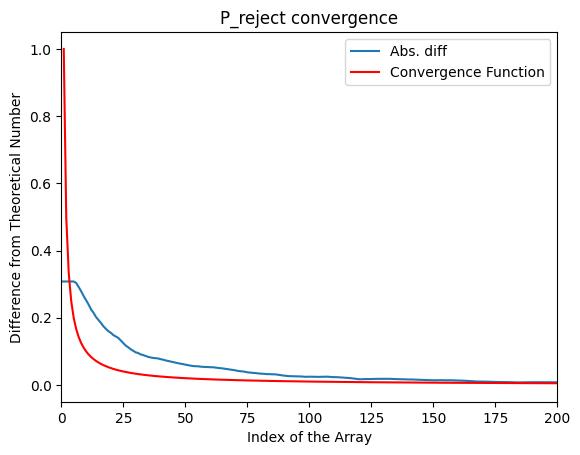

The estimated convergence speed function is f(N) = [1.]  /  N)


In [1041]:
convergence_estimation(np.array(P_reject_list).mean(axis=0), P_reject, 'P_reject')

/var/folders/yh/4jky_nln065c8nrzc6phgjjdt0k6bs/T/ipykernel_43257/909441150.py:7: RuntimeWarning: divide by zero encountered in divide
  return A / N  # You can choose a different function depending on the expected behavior


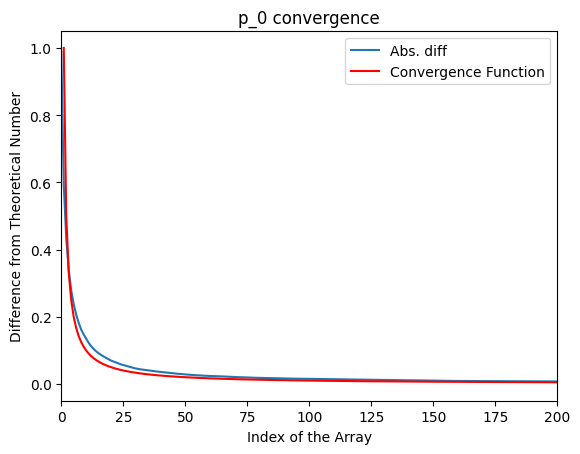

The estimated convergence speed function is f(N) = [1.]  /  N)


In [1042]:
convergence_estimation(np.array(p_0_list).mean(axis=0), p_0, 'p_0')

/var/folders/yh/4jky_nln065c8nrzc6phgjjdt0k6bs/T/ipykernel_43257/909441150.py:7: RuntimeWarning: divide by zero encountered in divide
  return A / N  # You can choose a different function depending on the expected behavior


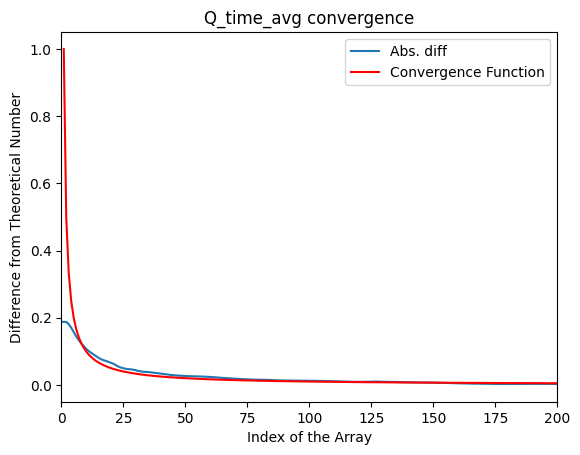

The estimated convergence speed function is f(N) = [1.]  /  N)


In [1043]:
convergence_estimation(np.array(Q_time_avg_list).mean(axis=0), Q_time_avg, 'Q_time_avg')

**Итого** вродек как, в среднем, наше чудо сходится со скоростью 1 / N, где N - номер итерации

p_0 и средее время ожидания так уж точно. 

В целом, функции написаны, переменные все в нотации, можно прогнать такое для всех, но зачем тратить время хороших людей, которые будут это читать? 



по доброй традиции вот мем в конце домашки: 

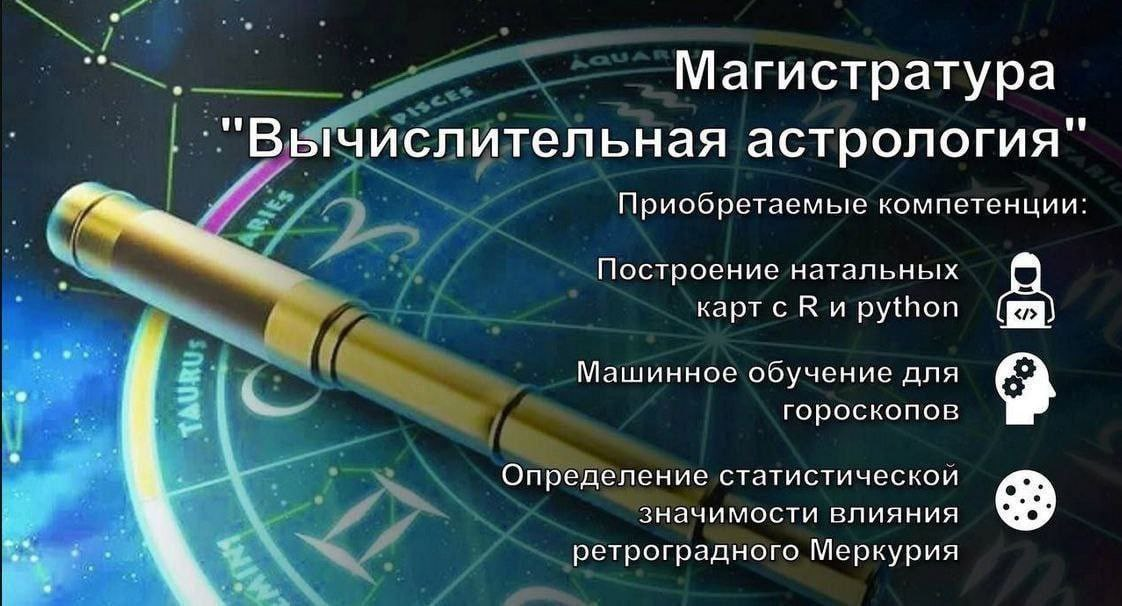